### Настройка Airflow

Для начала вам необходимо выполнить ряд команд чтобы настроить окружение для дальнейшей работы, это позволит первое время не заниматься настройкой среды исполнения, а сразу начать писать код и работать с Airflow.

In [ ]:
# Установка Airflow
!pip install apache-airflow==2.1.4

# Инициализация базы данных
!airflow db init

In [ ]:
# Создадим необходимые папки
!mkdir /root/airflow/dags
!touch /root/airflow/dags/dag.py

In [ ]:
# Включим веб-сервер
!airflow webserver -p 18273 -D

In [ ]:
# Создадим пользователя Airflow
!airflow users create \
          --username admin \
          --firstname admin \
          --lastname admin \
          --role Admin \
          --email admin@example.org \
          -p 12345

In [ ]:
# Запуск шедулера
!airflow scheduler -D

In [ ]:
# Последующие команды не имеют отношения к Airflow
# Они нужни только для корректной работы веб морды
# в среде Google Colab

!pip install pyngrok
!ngrok authtoken '' # найти его можно https://dashboard.ngrok.com/get-started/setup

# Эта команда просто отображет веб морду на другой адрес
# Его вы можете найти https://dashboard.ngrok.com/cloud-edge/status
# При каждом отключении ссылка будет меняться
!nohup ngrok http -log=stdout 18273 > /dev/null &

После запуска команды выше, перейдите по адресу в ngrok и подождите  пока появится DAG с именем dag

### Задача на разработку

ETL скрипт переписать с помощью Airflow. Использовать только 1 дату 2021-01-01 можно прописать в функции напрямую, захардкодить.

Вам необходимо обернуть ваш код в PythonOperator

*   Скачайте валюту за 2021-01-01 и положите в БД sqlite (использовать
PythonOperator чтобы скачать данные, можно использовать pandas)
*   Скачайте данные за 2021-01-01 и положите в БД sqlite (использовать PythonOperator чтобы скачать данные, можно использовать pandas)


Даг нужно написать в файл /root/airflow/dags/dag.py. Проверку можно сделать в веб интерфейсе. Прежде чем даг появится, может пройти ~ 2-3 минут.

In [ ]:
# Решение на разработку нужно оставить в этой ячейке
import pandas as pd
import sqlite3

CON = sqlite3.connect('currency.db', isolation_level=None)


from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.email_operator import EmailOperator
from airflow.operators.python_operator import PythonOperator


def extract_data(date, url, tmp_file):
    url = f'{url}{date}.csv'
    data = pd.read_csv(url).to_csv(tmp_file)
    return data

def sql_query(sql, conn=CON):
  df = None
  cursor = conn.cursor()
  query = cursor.execute(sql)
  if query.description:
    df = pd.DataFrame.from_records(data = query.fetchall(), columns = [column[0] for column in query.description])
  cursor.close()
  return df

def load_data(tmp_file, table_name, conn=CON, **context) -> None:
    """ Load to DB
    """
    data = pd.read_csv(tmp_file)# Изменение read_csv
    data["insert_time"] = pd.to_datetime("now")
    data.to_sql(table_name, conn, if_exists='replace', index=False)
    count = sql_query(f"select count(*) from '{table_name}'")
    print(f"Records in table '{table_name}':", count.values)

with DAG(dag_id='dag',
         default_args={'owner': 'airflow'},
         schedule_interval='@daily',
         start_date=days_ago(1)
    ) as dag:

    extract_data = PythonOperator(
        task_id='extract_data',
        python_callable=extract_data,
        op_kwargs={'date': '2021-01-01',
            'url': 'https://raw.githubusercontent.com/dm-novikov/stepik_airflow_course/main/data_new/',
            'tmp_file': '/tmp/file.csv'},
        dag=dag
    )

    load_data = PythonOperator(
        task_id='load_data',
        python_callable=load_data,
        dag=dag,
        op_kwargs={
            'tmp_file': '/tmp/file.csv',
            'table_name': 'currency'
        }
    )


    extract_data >> load_data

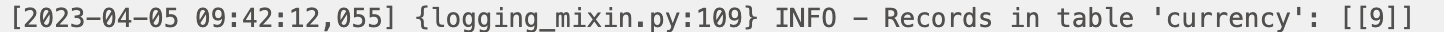

In [ ]:
# чтобы првоерить решение можете обратиться к вашей базе данных таким образом
%reload_ext sql

%config SqlMagic.feedback=False

%config SqlMagic.autopandas=True

%sql sqlite:////currency.db

%sql select * from currency

   sqlite:////content/currency.db
 * sqlite:////currency.db


,Unnamed: 0,currency,value,date,insert_time
0,0,EUR,38,2021-01-01,2023-04-05 09:42:11.947544
1,1,EUR,65,2021-01-01,2023-04-05 09:42:11.947544
2,2,EUR,74,2021-01-01,2023-04-05 09:42:11.947544
3,3,EUR,42,2021-01-01,2023-04-05 09:42:11.947544
4,4,EUR,23,2021-01-01,2023-04-05 09:42:11.947544
5,5,EUR,48,2021-01-01,2023-04-05 09:42:11.947544
6,6,EUR,86,2021-01-01,2023-04-05 09:42:11.947544
7,7,EUR,74,2021-01-01,2023-04-05 09:42:11.947544
8,8,EUR,24,2021-01-01,2023-04-05 09:42:11.947544
